# Normalizing Flows

This notebook is intended to investigate the representative power of normalizing flows. Any distribution can be approximated using normalizing flows. Here, we will investigate how well normalizing flows can represent difficult ditributions such as the banana distribution and multimodal distributions with complex correlations. For ease of visualization, only 2d distributions will be investigated here. 


## Forward model

Here we use normalizing flows to approximate the posterior for our forward model

In [8]:
import torch
import math
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
from scipy.optimize import minimize
from torch.utils.data import DataLoader, TensorDataset
import scipy
import time

In [2]:
# define our forward model
def G(L,N,dt,tFinal,Sigma,R_film0, VR, Cv, Qmin, jmin):
    # INPUTS:
    #   L       = domain length (1D)
    #   N       = number of nodes in domain
    #   dt      = time step
    #   Sigma   = model parameter
    #   R_film0 = model parameter; initial film resistance
    #   VR      = model parameter; voltage ramp
    #   Cv      = model parameter
    #   Qmin    = model parameter
    #   jmin    = model parameter
    #
    # OUTPUTS:
    #   Thickness
    #   Resistance
    #   Current
    #   Xi          = indicator of identifiability of Qmin, jmin
    #                 0 -> both identifiable
    #                 1 -> jmin unidentifiable
    #                -1 -> Qmin unidentifiable


    # Initialize necessary variables
    BC_anode = 0 
    R_film = R_film0
    Q = 0
    h = 0
    i = 0
    Resistance = np.zeros((math.floor(tFinal)+1,1))
    Thickness  = np.zeros((math.floor(tFinal)+1,1))
    Current    = np.zeros((math.floor(tFinal)+1,1))

    h_x = L/(N-1)
    e = np.ones((N,1))
    
    # Assemble A(phi) = S
    a = np.ones(N)
    b = np.ones(N-1)
    A = Sigma*(-2*np.diag(a,0)+np.diag(b,-1)+np.diag(b,1))/h_x**2
    A[-1,-2]=0
    A[0,1] = 2*Sigma/h_x**2

    SN_fac = -2*Sigma/h_x**2
    j_fac = Sigma/h_x
    S = np.zeros((N,1))
    
    t = 0
    chk_tol = dt/10
    while (t<tFinal):
        i += 1
        BC_anode = BC_anode + VR*dt
        S[-1] = SN_fac*BC_anode
        a = -R_film*Sigma
        A[0,0] = SN_fac*(1-h_x/a)
        
        phi = np.linalg.solve(A,S)
        j = j_fac*(phi[1]-phi[0])
        Q = Q + j*dt

        if (Q>Qmin)and(j>jmin): # threshold criterion
            h = h + Cv*j*dt # film thickness
            rho_j = np.maximum(8e6*np.exp(-0.1*j),2e6) # resistivity of film
            R_film = R_film + rho_j*Cv*j*dt # film resistance
        
        t += dt
        if ((t%1)<chk_tol)or(((t%1)-1)>-chk_tol):
            tind = int(np.rint(t))
            Resistance[tind,0] = R_film
            Thickness[tind,0] = h
            Current[tind,0] = j
        
        Xi = 0

    return Thickness, Resistance, Current, Xi

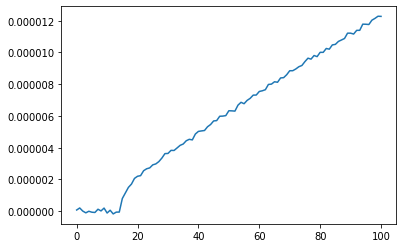

In [3]:
Sigma       = 0.14  # 
Cv          = 1e-7  #
R_film0     = 0.5   # Initial film resistance
VR          = 1     # Voltage Ramp
jmin        = 1     #
Qmin        = 150   #
rho_j       = 5e6   #
L           = 0.0254# Domain length
Nx          = 11    # Number of spatial domain nodes
dt          = 0.1   # Forward model time step
tFinal      = 100   # Forward model final time
sig_thk     = 1e-7  # noise for thickness data

n_samples = 5

Thk, Res, Cur, Xi = G(L, Nx, dt, tFinal, Sigma, R_film0, VR, Cv, Qmin, jmin)

Thk_d = np.zeros((n_samples, np.shape(Thk)[0]))
for i in range(n_samples):
    Thk_d[i,:] = Thk[:,0] + np.random.normal(0, sig_thk, np.shape(Thk[:,0]))


plt.figure(1)
plt.plot(Thk_d[0,:])



#### Now we create the normalizing flow classes and train the model using data generated from our forward model

In [21]:
# we first create the base inference network

class encoder(nn.Sequential):
    def __init__(self, layers, nodes, act):
        super(encoder, self).__init__()
        
        self.add_module('full_conn0', nn.Linear(1, nodes))
        self.add_module('act0', act)
        for i in range(layers-1):
            self.add_module('full_conn%d'%(i+1), nn.Linear(nodes, nodes))
            self.add_module('act%d'%(i+1), act)

        
        self.add_module('full_conn%d'%(layers), nn.Linear(nodes, 1))

# now the decoding network (mirrors the encoder)

class decoder(nn.Sequential):
    def __init__(self, layers, nodes, act):
        super(decoder, self).__init__()
        
        self.add_module('full_conn0', nn.Linear(1, nodes))
        self.add_module('act0', act)
        for i in range(layers-1):
            self.add_module('full_conn%d'%(i+1), nn.Linear(nodes, nodes))
            self.add_module('act%d'%(i+1), act)

        
        self.add_module('full_conn%d'%(layers), nn.Linear(nodes, 1))
    

# now define the flow layers

class PlanarFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        act = torch.tanh
        self.D = D
        
        self.w = nn.Parameter(torch.empty(D))
        self.b = nn.Parameter(torch.empty(1))
        self.u = nn.Parameter(torch.empty(D))
        self.act = act
        self.act_deriv = lambda x: 1 - torch.tanh(x)**2
        
        nn.init.normal_(self.w)
        nn.init.normal_(self.u)
        nn.init.normal_(self.b)
        
        #self.a = nn.Parameter(0*torch.ones(1))
        #nn.init.normal_(self.a)
        
    def forward(self, z):
        
        dot = torch.sum(self.w*self.u)
        u = self.u + (torch.log(1+torch.exp(dot))-1-dot)*self.w/torch.sum(self.w**2)
        lin = (z @ self.w + self.b).unsqueeze(1)
        f = z + u * self.act(lin)
        phi = self.act_deriv(lin) * self.w
        log_det = torch.log(torch.abs(1+phi@u))
        
        #f = z + self.a
        #log_det = 1
        
        return f, log_det

class RadialFlow(nn.Module):
    def __init__(self, D):
        super().__init__()
        
        self.D = D
        self.z0 = nn.Parameter(torch.empty(D))
        self.beta = nn.Parameter(torch.empty(1))
        self.alpha = nn.Parameter(torch.empty(1))
        
        nn.init.normal_(self.z0)
        nn.init.normal_(self.alpha)
        nn.init.normal_(self.beta)
        
    def forward(self, z):
        beta = torch.log(1+torch.exp(self.beta)) - torch.abs(self.alpha) # to ensure layer is invertible
        r = torch.linalg.vector_norm(z - self.z0, dim = 1)

        h = beta / (torch.abs(self.alpha) + r)
        h_prime = -beta * r / (torch.abs(self.alpha)+r) ** 2
        f = z + h.unsqueeze(1)*(z-self.z0)

        log_det = (self.D-1) * torch.log(1+h) \
                  + torch.log(1+h+h_prime)       
        return f, log_det 
    
    
class G_torch(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, z):
        # Define all of the parameters
        Sigma       = 0.14  # 
        #Cv          = 1e-7  #
        R_film0     = 0.5   # Initial film resistance
        VR          = 1     # Voltage Ramp
        #jmin        = 1     #
        #Qmin        = 150   #
        rho_j       = 5e6   #
        L           = 0.0254# Domain length
        N          = 11    # Number of spatial domain nodes
        dt          = 0.1   # Forward model time step
        tFinal      = 100   # Forward model final time
        
        
        batch_size = np.shape(z)[0]
        #z = torch.exp(z)
        #Cv = torch.pow(10.0, -z)#[:,0])
        Qmin = z#[:,1]
        #jmin = z#[:,2]
        Cv = 1e-7
        #Qmin = 150
        jmin = 1.0
        
        Thk_d = torch.zeros((batch_size, tFinal+1), device = device)
        
        h_x = L/(N-1)
        SN_fac = -2*Sigma/h_x**2
        j_fac = Sigma/h_x
        e = torch.ones((N,1), device = device)
        al = torch.ones((N,), device = device)
        b = torch.ones((N-1,), device = device)
        
        for k in range(batch_size):
            
            # Initialize necessary variables
            BC_anode = 0 
            R_film = R_film0
            Q = 0
            h = 0 
            i = 0
            Resistance = torch.zeros((math.floor(tFinal)+1,1), device = device)
            Thickness  = torch.zeros((math.floor(tFinal)+1,1), device = device)
            Current    = torch.zeros((math.floor(tFinal)+1,1), device = device)

            
            # Assemble A(phi) = S

            A = Sigma*(-2*torch.diag(al,0)+torch.diag(b,-1)+torch.diag(b,1))/h_x**2
            A[-1,-2]=0
            A[0,1] = 2*Sigma/h_x**2
            A[0,0] = 0
            A = A.repeat(1002, 1, 1)
            A.to(device)

            R_film = R_film0*torch.ones((1000 + 2,), device = device)
            h = torch.zeros((1000 + 2, ), device = device)
            rho_j = torch.zeros((1002, ), device = device)
            j = torch.zeros((1002, ), device = device)
            Q = torch.zeros((1002, ), device = device)
            phi = torch.zeros((1000 + 2, N), device = device)
            
            S = torch.zeros((1000 + 2, N), device = device)
            Si = S + 0.
    
            t = 0
            chk_tol = dt/10
            while (t<tFinal):
                i = i + 1
                BC_anode = BC_anode + VR*dt
                S[i-1,-1] = SN_fac*BC_anode
                a = -R_film[i-1]*Sigma
                A[i,0,0] = SN_fac*(1-h_x/a)
                #U, s, Vh = torch.linalg.svd(A[:,:,i])
                #Ai = torch.transpose(Vh,0,1)@torch.diag(1/s)@torch.transpose(U,0,1)
                phi[i-1,:] = torch.linalg.solve(A[i,:,:], S[i-1,:])#torch.matmul(Ai, S[i-1,:])
                j[i] = j_fac*(phi[i-1,1]-phi[i-1,0])
                Q[i] = Q[i-1] + j[i]*dt

                if (Q[i]>Qmin[k])and(j[i]>jmin): # threshold criterion
                    h[i] = h[i-1] + Cv*j[i]*dt # film thickness
                    rho_j[i] = torch.maximum(8e6*torch.exp(-0.1*j[i]),2e6*torch.ones((1,), device = device)) # resistivity of film
                    R_film[i] = R_film[i-1] + rho_j[i]*j[i]*Cv*dt # film resistance
        
                t = t + dt
                if ((t%1)<chk_tol)or(((t%1)-1)>-chk_tol):
                    tind = int(np.rint(t))
                    Resistance[tind,0] = R_film[i]
                    Thickness[tind,0] = h[i]
                    Current[tind,0] = j[i]
        
            Xi = 0
            
        
            Thk_d[k,:] = Thickness[:,0]
            
        return Thk_d

        
        
        
        

In [22]:
# now we can define our model

class NormalizingFlowVI(nn.Module):
    def __init__(self, layers, nodes, flow_layers, act=nn.ReLU()):
        super().__init__()
        
        self.encoder_mean = encoder(layers, nodes, act)
        self.encoder_logvar = encoder(layers, nodes, act)
        self.decoder_mean = TrueDecoder() # decoder(layers, nodes, act)
        self.decoder_logvar = nn.Parameter(torch.empty(1))
        
        self.flow = nn.Sequential()
        #self.flow.add_module('identity', nn.Identity())
        for i in range(flow_layers):
            self.flow.add_module('flow%d'%(i+1), PlanarFlow(1))
    
    def forward(self, x):

        batch_size = x.shape[0]
        zmu, zlogvar = self.encoder_mean(x), self.encoder_logvar(x)
        sigma = torch.exp(0.5*zlogvar)
        z = self._reparameterize(zmu, zlogvar)
        z0 = z.clone()
        
        log_prob_z0 = torch.sum( \
                        -0.5 * torch.log(torch.tensor(2*math.pi)) - \
                            zlogvar - 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        
        log_det = torch.zeros((batch_size,))
        for layer in self.flow:
            z, ld = layer(z)
            log_det += ld
         
        log_prob_zk = torch.sum(-0.5 * (torch.log(torch.tensor(2*math.pi)) + z**2), axis = 1)
        
        xmu = self.decoder_mean(z)
        
        log_px_zk = torch.sum(self.gaussian_log_prob(x, xmu, self.decoder_logvar), 1)
        
        return z0, zmu, zlogvar, z, xmu, self.decoder_logvar, \
               log_prob_z0, log_det, log_prob_zk, log_px_zk 
    
    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).type_as(mu)
        return mu + std * eps
    
    def gaussian_log_prob(self, x, mu, logvar):
        return -0.5*(math.log(2*math.pi) + logvar + (x-mu)**2/torch.exp(logvar))
    
class Flow(nn.Module):
    def __init__(self, D, flow_layers, act=nn.ReLU()):
        super().__init__()
        
        self.flow = nn.Sequential()
        #self.flow.add_module('identity', nn.Identity())
        for i in range(flow_layers):
            #if np.mod(i, 2)==0:
            self.flow.add_module('flow%d'%(i+1), PlanarFlow(D))
            #else:
            #self.flow.add_module('flow%d'%(i+1), RadialFlow(D))

    
    def forward(self, zmu, zlogvar):
        batch_size = zmu.shape[0]
        sigma = torch.exp(0.5*zlogvar)
        z = self._reparameterize(zmu, zlogvar)
        z0 = z.clone()
        
        log_prob_z0 = torch.sum(- 0.5 * ((z-zmu)/sigma) ** 2, axis = 1)
        
        log_det = torch.zeros((batch_size,), device = device)
        for layer in self.flow:
            z, ld = layer(z)
            log_det += ld
         
        mu_pzk = 150
        var_pzk = 20**2
        log_prob_zk = torch.sum(-0.5 * ((z-mu_pzk)**2/var_pzk), axis = 1) # prior of N(0,1)
        
        return z0, zmu, zlogvar, z, \
               log_prob_z0, log_det, log_prob_zk
    
    def _reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size()).type_as(mu)
        return mu + std * eps
    
    def gaussian_log_prob(self, x, mu, logvar):
        return -0.5*(math.log(2*math.pi) + logvar + (x-mu)**2/torch.exp(logvar))

In [28]:
# now load the data and train the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

flow_layers = 5
D = 1

C_D = np.var(Thk_d, axis = 0)
C_D = torch.from_numpy(C_D)
C_D = C_D.to(device)

zmu = 110
zlogvar = 2*np.log(20)


batch_size = n_samples // 1
epochs = 25

ForwardModel = G_torch()
ForwardModel.to(device)

# process the data
dataset = TensorDataset(torch.tensor(Thk_d).float(), torch.tensor(Thk_d).float())
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# initialize the model and optimizer
NF = Flow(D, flow_layers)
NF.to(device)
optimizer = torch.optim.Adam(NF.parameters(), lr=0.0003)

#NF.flow.flow1.u = nn.Parameter(1000*torch.ones((1,)))

'''
a_v = torch.linspace(5, 200, 50)
l_v = np.zeros(np.shape(a_v))
thk_d = torch.tensor(Thk_d).float()
b = n_samples
for i in range(len(a_v)):
    NF.flow.flow1.a = nn.Parameter(a_v[i]*torch.ones((1,)))
    zMu = zmu*torch.ones((b,D))
    zLV = zlogvar*torch.ones((b,D))
    _,_,_,z, lpz0, ld, lpzk = NF.forward(zMu, zLV)
    thk_out = ForwardModel(z)
    lr = torch.sum(-0.5*((torch.tile(thk_out, (b,1,1))-torch.tile(thk_d, (b,1,1)))**2/torch.tile(C_D, (b, b, 1))), (0,2))
    l_v[i] = torch.mean(lpz0 - ld - lr - lpzk).detach().numpy()
    
plt.figure(0)
plt.plot(a_v.detach().numpy(), l_v)
'''

# initialize loss list
t0 = time.time()
loss_v = np.zeros((epochs,))
NF.train()
# train
torch.autograd.set_detect_anomaly(False)
for epoch in range(epochs):
    for n, (_, thk_d) in enumerate(data_loader):
        thk_d = thk_d.to(device)
        b = thk_d.shape[0]
        
        NF.zero_grad()
        zMu = zmu*torch.ones((b,D), device = device)
        zLV = zlogvar*torch.ones((b,D), device = device)
        _,_,_,z, lpz0, ld, lpzk = NF.forward(zMu, zLV) 
        thk_out = ForwardModel(z)
        #
        #print('thk_out: ', np.shape(thk_out))
        #print('thk_d  : ', np.shape(thk_d))
        #print('Cd     : ', np.shape(C_D))
        #print('diff: ', np.shape((thk_out-thk_d)/C_D))
        #
        lr = torch.sum(-0.5*((torch.tile(thk_out, (b,1,1))-torch.tile(thk_d, (b,1,1)))**2/torch.tile(C_D, (b, b, 1))), (0,2))
        

        loss = torch.mean(lpz0 - ld - lr - lpzk)
        
        #print(np.shape(lpz0-lpzk-ld-lr))
        
        loss.backward()
        #
        #print('u: ', NF.flow.flow1.u, '  grad: ', NF.flow.flow1.u.grad)
        #print('w: ', NF.flow.flow1.w, '  grad: ', NF.flow.flow1.w.grad)
        #print('b: ', NF.flow.flow1.b, '  grad: ', NF.flow.flow1.b.grad)
        #
        #print('a: ', NF.flow.flow1.a, '  grad: ', NF.flow.flow1.a.grad)
        optimizer.step()
        
    loss_v[epoch] = loss.cpu().detach().numpy()
        
    if np.mod(epoch, epochs//25)==0:
        #
        #print('Lpz0: ', torch.mean(lpz0))
        #print('Log det: ', torch.mean(ld))
        #print('Rec loss: ', torch.mean(lr))
        #print('lpzk: ', torch.mean(lpzk))
        #
        print('Epoch: ', epoch)
        print('Loss: ', loss.cpu().detach().numpy())
        #print('lpz0: ', lpz0)
        #print('ld: ', ld)
        #print('lpzk: ', lpzk)
        #print('lr: ', lr)
        #print('p_log_post: ', p_log_post)

t_end = time.time()

print("Ellapsed time: ", t_end-t0)
   


Epoch:  0
Loss:  2410.1488351662215
Epoch:  1
Loss:  2045.8522546044617
Epoch:  2
Loss:  2184.5175966800525
Epoch:  3
Loss:  2014.7434140040477
Epoch:  4
Loss:  2661.5069908585356
Epoch:  5
Loss:  2393.8203700079957
Epoch:  6
Loss:  2100.568127705311
Epoch:  7
Loss:  2535.228007469155
Epoch:  8
Loss:  2627.643730772363
Epoch:  9
Loss:  1910.511842270103
Epoch:  10
Loss:  2049.51005035256
Epoch:  11
Loss:  1607.8210225997657
Epoch:  12
Loss:  2810.9950015692684
Epoch:  13
Loss:  2568.046181174098
Epoch:  14
Loss:  2458.7707381456394
Epoch:  15
Loss:  1614.6764332696475
Epoch:  16
Loss:  3013.008167994952
Epoch:  17
Loss:  1877.1830825358852
Epoch:  18
Loss:  2440.98594381338
Epoch:  19
Loss:  3062.411137514063
Epoch:  20
Loss:  2410.7784614319817
Epoch:  21
Loss:  1692.6663806489655
Epoch:  22
Loss:  2458.865968655943
Epoch:  23
Loss:  2706.267167764506
Epoch:  24
Loss:  2551.25098984623
Ellapsed time:  27.896540641784668


KL:  746.9174871276391
Learned Model:  Flow(
  (flow): Sequential(
    (flow1): PlanarFlow()
    (flow2): PlanarFlow()
    (flow3): PlanarFlow()
    (flow4): PlanarFlow()
    (flow5): PlanarFlow()
  )
)


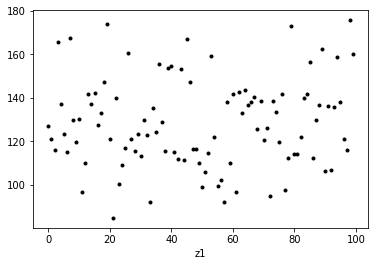

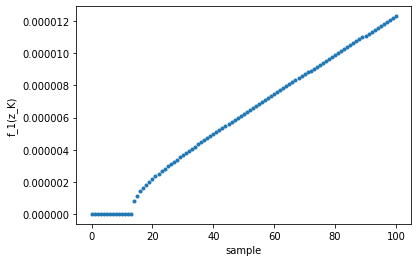

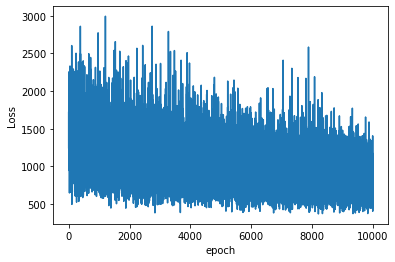

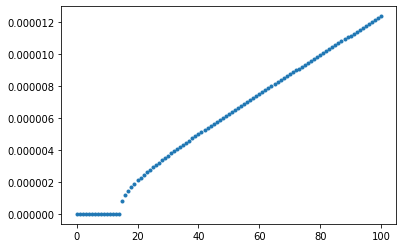

In [264]:
M = 100
zMu = zmu*torch.ones((M,D))
zLV = zlogvar*torch.ones((M,D))
_,_,_,z,_,_,_ = NF.forward(zMu, zLV)

y_out = ForwardModel(z)
L_recon_sample = torch.mean(torch.sum(-0.5*((y_out[:n_samples,:]-thk_d)**2/C_D), 1))

y_out = y_out.detach().numpy()
plt.figure(10)
for i in range(D):
    plt.subplot(D, 1, i+1)
    plt.plot((z[:,i].detach().numpy()), 'k.')
    plt.xlabel('z%d'%(i+1))

plt.figure(1)
plt.plot(y_out[0,:] ,'.')
plt.xlabel('sample')
plt.ylabel('f_1(z_K)')
plt.figure(2)
plt.plot(loss_v)
#plt.plot([0,epochs],[0,0],'k--')
plt.xlabel('epoch')
plt.ylabel('Loss')
print("KL: ", loss_v[-1])
print("Learned Model: ", NF)

z_true = torch.ones((1,3))
z_true[0,0] = (7)
z_true[0,1] = (150)
z_true[0,2] = (1)
z_true = torch.ones((1, 1))*(150)
y_true = ForwardModel(z_true)
L_true = torch.mean(torch.sum(-0.5*((y_true.repeat(n_samples,1)-thk_d)**2/C_D), 1))
plt.figure(20)
plt.plot(y_true[0,:], '.')

#print('Recon Loss Sample: ', L_recon_sample)
#print('True Loss: ', L_true)

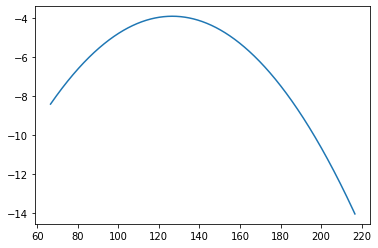

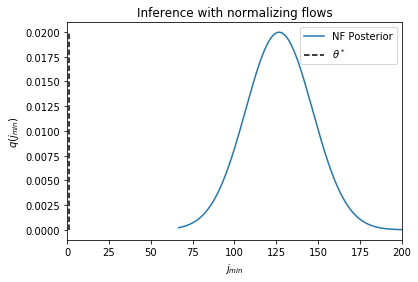

In [265]:
n_s = 1000
z_eval = np.array(np.linspace(50, 200, n_s))
#z_eval = np.log(z_eval) # log of the params as input
#z_eval_bayes = np.linspace(-1.1, 1.1, n_s)
z_eval_torch = torch.Tensor(z_eval)
zmu0 = zmu*torch.ones((1,))
zlogvar0 = zlogvar*torch.ones((1,))
sigma = torch.exp(0.5*zlogvar0)

log_prob_z0 = 0

zprob = np.zeros(np.shape(z_eval))
bayes_post_v = np.zeros(np.shape(z_eval))
zk = np.zeros(np.shape(z_eval))
for i in range(len(z_eval)):
    z = torch.tensor(z_eval[i]).reshape(1,1).float()
    log_prob_z0 = -0.5 * torch.log(torch.tensor(2*math.pi)) - \
                            0.5*zlogvar0 - 0.5 * ((z_eval[i]-zmu0)/sigma) ** 2
        
    log_det = torch.zeros((1,))
    for layer in NF.flow:
        z, ld = layer(z+0.)
        log_det += ld
    zk[i] = z
    zprob[i] = (torch.sum(log_prob_z0 - log_det).detach().numpy())
    #bayes_post_v[i] = np.exp(logLike(y_d, z_eval_bayes[i], model))*prior(z_eval_bayes[i])
    
#dtheta = z_eval_bayes[1]-z_eval_bayes[0]
#Z = np.sum(0.5*(bayes_post_v[:-1]+bayes_post_v[1:]))*dtheta

#bayes_post_v = bayes_post_v/Z # normalize
            
# we now sort the NF output
#zk = np.exp(zk)
sort_inds = np.argsort(zk)
zk = zk[sort_inds]
zprob = zprob[sort_inds]
    
# now normalize the posterior (not log posterior)
nf_post = np.exp(zprob+3.00)
Z = np.sum(0.5*(nf_post[:-1]+nf_post[1:])*np.diff(zk))
nf_post = nf_post/Z

# clip the output for better plotting
#nf_post[nf_post > 3.0*np.max(bayes_post_v)] = 3.0*np.max(bayes_post_v)

plt.figure(1)
plt.plot(zk, zprob)
plt.figure(2)
#plt.plot(z_eval_bayes, bayes_post_v, label="Bayesian Posterior")
plt.plot(zk, nf_post, label="NF Posterior")
plt.plot(np.array([jmin, jmin]), np.array([0, np.max(nf_post)]), 'k--', label = r'$\theta^*$')
plt.xlim([0, 200])
plt.xlabel(r'$j_{min}$')
plt.ylabel(r'$q(j_{min})$')
plt.title('Inference with normalizing flows')

plt.legend()




In [33]:
n = 4
x = np.array([np.linspace(0, 1, n), np.linspace(-1, 0, n)])
print(x)

[[ 0.          0.33333333  0.66666667  1.        ]
 [-1.         -0.66666667 -0.33333333  0.        ]]


In [163]:
x = torch.normal(0, 1, (1, 5))
print(x)
print(x.repeat(3, 2, 1))

tensor([[-0.4408,  0.0250, -0.7024, -0.5210,  1.4226]])
tensor([[[-0.4408,  0.0250, -0.7024, -0.5210,  1.4226],
         [-0.4408,  0.0250, -0.7024, -0.5210,  1.4226]],

        [[-0.4408,  0.0250, -0.7024, -0.5210,  1.4226],
         [-0.4408,  0.0250, -0.7024, -0.5210,  1.4226]],

        [[-0.4408,  0.0250, -0.7024, -0.5210,  1.4226],
         [-0.4408,  0.0250, -0.7024, -0.5210,  1.4226]]])


In [267]:
import time

cuda:0
